In [1]:
!pip install category_encoders

In [2]:
!pip install imbalanced-learn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Load Libraries*

In [40]:
import pandas as pd
import numpy as np
from category_encoders import *



 **Read Train file**

In [41]:
test_Tr=pd.read_csv('/content/drive/MyDrive/Hackathon-AV/test_mSzZ8RL.csv')
tr=pd.read_csv('/content/drive/MyDrive/Hackathon-AV/train_s3TEQDk.csv')


In [42]:
train=pd.read_csv('/content/drive/MyDrive/Hackathon-AV/train_s3TEQDk.csv')
test=pd.read_csv('/content/drive/MyDrive/Hackathon-AV/test_mSzZ8RL.csv')
tt=pd.read_csv('/content/drive/MyDrive/Hackathon-AV/test_mSzZ8RL.csv')

Check for missing values & Impute missing values

In [43]:


train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [44]:
train['Credit_Product']

0          No
1          No
2          No
3          No
4          No
         ... 
245720    NaN
245721     No
245722     No
245723     No
245724     No
Name: Credit_Product, Length: 245725, dtype: object

In [45]:
train['Credit_Product'].fillna('No',inplace=True)



check missiing values after imputing

In [46]:
train.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [47]:
train.drop_duplicates(keep='first',inplace=True)

In [48]:
import imblearn

ImportError: ignored

## EDA

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns





*   **Male customers are higher than female customers**
*   **Highest number of customers are in between Age 20-30**



Text(0.5, 1.0, 'Region wise customer distribution')

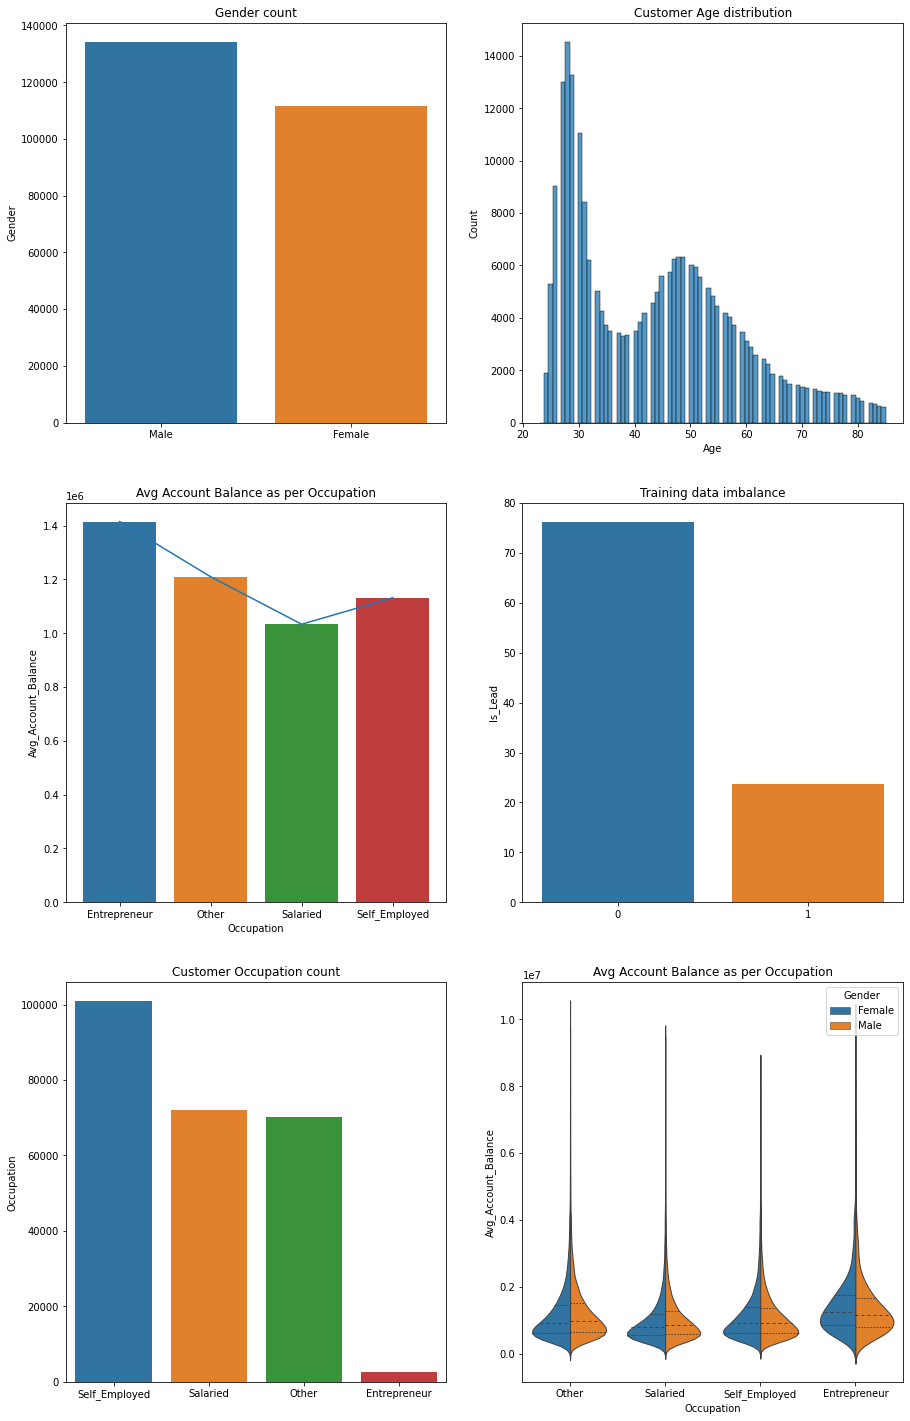

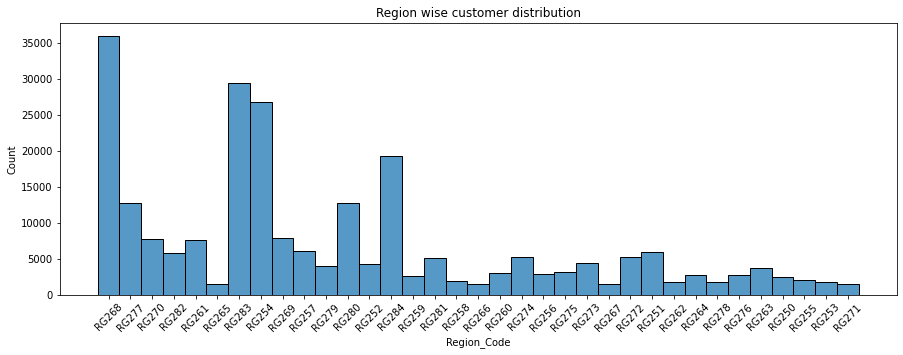

In [50]:
figure,axes=plt.subplots(nrows=3,ncols=2,figsize=(15,25))
figure1,axes1=plt.subplots(nrows=1,ncols=1,figsize=(15,5))

sns.histplot(data=train,x='Age',ax=axes[0,1],legend=True)
sns.barplot(x=train['Occupation'].value_counts().index,y=train['Occupation'].value_counts(),ax=axes[2,0])
sns.barplot(x=train.groupby('Occupation')['Avg_Account_Balance'].mean().index,y=train.groupby('Occupation')['Avg_Account_Balance'].mean(),ax=axes[1,0])
#train.groupby('Occupation')['Avg_Account_Balance'].mean()
sns.lineplot(x=train.groupby('Occupation')['Avg_Account_Balance'].mean().index,y=train.groupby('Occupation')['Avg_Account_Balance'].mean(),ax=axes[1,0])
sns.barplot(x=train['Is_Lead'].value_counts().index,y=train['Is_Lead'].value_counts(normalize=True)*100,ax=axes[1,1])
sns.barplot(x=train['Gender'].value_counts().index,y=train['Gender'].value_counts(),ax=axes[0,0])
sns.violinplot(y=train['Avg_Account_Balance'],x=train['Occupation'],ax=axes[2,1],hue=train['Gender'],split=True, inner="quart", linewidth=1)
sns.histplot(data=train,x='Region_Code',ax=axes1,legend=True)
plt.xticks(rotation=45)
axes[0,0].set_title("Gender count")
axes[0,1].set_title("Customer Age distribution")
axes[1,0].set_title("Avg Account Balance as per Occupation")
axes[1,1].set_title('Training data imbalance')
axes[2,0].set_title('Customer Occupation count')
axes[2,1].set_title('Avg Account Balance as per Occupation')
axes1.set_title('Region wise customer distribution')

**most of the customers have channel code as X1**

In [ ]:
plt.figure(figsize=(10,10))
data=train['Channel_Code'].value_counts()
plt.pie(x=data,autopct='%.1f%%',explode=[0.05]*4,labels=data.index)

In [ ]:
# train['Vintage'].value_counts()
sns.histplot(data=train,x='Vintage')

## Data Preprocessing

In [22]:
train.drop('ID',axis=1,inplace=True)
test.drop('ID',axis=1,inplace=True)

In [23]:
cat_cols=['Gender','Occupation','Credit_Product','Is_Active','Channel_Code']
num_cols=list(set(train.columns.to_list()).difference(set(cat_cols)))
num_cols


['Is_Lead', 'Age', 'Region_Code', 'Avg_Account_Balance', 'Vintage']

In [24]:
X_enc=train.drop('Is_Lead',axis=1)

y_enc=train[['Is_Lead']]
enc=TargetEncoder(cols=['Region_Code'])
train_enc=enc.fit_transform(X_enc,y_enc)
test_enc=enc.transform(test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [25]:
train_enc.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,Female,73,0.299800,Other,X3,43,No,1045696,No
1,Female,30,0.231951,Salaried,X1,32,No,581988,No
2,Female,56,0.299800,Self_Employed,X3,26,No,1484315,Yes
3,Male,34,0.144301,Salaried,X1,19,No,470454,No
4,Female,30,0.192143,Salaried,X1,33,No,886787,No


In [26]:
bin=[0,25,50,75,100]
lable=[1,2,3,4]
train_enc['Age_bins']=pd.cut(train_enc['Age'],bins=bin,labels=lable)
test_enc['Age_bins']=pd.cut(test_enc['Age'],bins=bin,labels=lable)

In [27]:
train_enc.head()
test_enc.dtypes

Gender                   object
Age                       int64
Region_Code             float64
Occupation               object
Channel_Code             object
Vintage                   int64
Credit_Product           object
Avg_Account_Balance       int64
Is_Active                object
Age_bins               category
dtype: object

In [28]:
from sklearn.preprocessing import MinMaxScaler
sacled_cols=train_enc[['Vintage','Avg_Account_Balance']]
sacled_cols2=test_enc[['Vintage','Avg_Account_Balance']]
scaler=MinMaxScaler()
train_trf=scaler.fit_transform(sacled_cols)
test_trf=scaler.transform(sacled_cols2)
scaled_cols=pd.DataFrame(train_trf,columns=['Vintage','Avg_Account_Balance'])
scaled_cols2=pd.DataFrame(test_trf,columns=['Vintage','Avg_Account_Balance'])

train_enc[['Vintage','Avg_Account_Balance']]=pd.DataFrame(scaled_cols,columns=['Vintage','Avg_Account_Balance'])
test_enc[['Vintage','Avg_Account_Balance']]=pd.DataFrame(scaled_cols2,columns=['Vintage','Avg_Account_Balance'])

test_enc

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Age_bins
0,Male,29,0.212854,Other,X1,0.140625,Yes,0.069844,No,2
1,Male,43,0.299800,Other,X2,0.328125,NaN,0.087574,No,2
2,Male,31,0.144301,Salaried,X1,0.054688,No,0.018890,No,2
3,Male,29,0.219916,Other,X1,0.203125,No,0.082012,No,2
4,Female,29,0.144301,Other,X1,0.093750,No,0.061590,No,2
...,...,...,...,...,...,...,...,...,...,...
105307,Male,52,0.299800,Salaried,X2,0.617188,Yes,0.408642,Yes,3
105308,Male,55,0.231951,Other,X2,0.617188,Yes,0.110187,No,3
105309,Male,35,0.212854,Salaried,X4,0.062500,No,0.162898,No,2
105310,Male,53,0.212854,Other,X3,0.671875,No,0.069342,Yes,3


In [29]:
train_enc.dtypes

Gender                   object
Age                       int64
Region_Code             float64
Occupation               object
Channel_Code             object
Vintage                 float64
Credit_Product           object
Avg_Account_Balance     float64
Is_Active                object
Age_bins               category
dtype: object

In [30]:
X_dummy = train_enc

y = train.loc[:,'Is_Lead']

In [31]:
X_dummy.shape
y.shape

(245725,)

In [32]:
X=pd.get_dummies(columns=cat_cols, data=X_dummy, prefix=cat_cols, prefix_sep="_",drop_first=True)

In [33]:
X['Vintage_year']=(train['Vintage']/12)
X

,Age,Region_Code,Vintage,Avg_Account_Balance,Age_bins,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yes,Is_Active_Yes,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Vintage_year
0,73,0.299800,0.281250,0.099205,3,0,1,0,0,0,0,0,1,0,3.583333
1,30,0.231951,0.195312,0.054321,2,0,0,1,0,0,0,0,0,0,2.666667
2,56,0.299800,0.148438,0.141660,3,0,0,0,1,0,1,0,1,0,2.166667
3,34,0.144301,0.093750,0.043525,2,1,0,1,0,0,0,0,0,0,1.583333
4,30,0.192143,0.203125,0.083823,2,0,0,1,0,0,0,0,0,0,2.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245720,51,0.301035,0.796875,0.184373,3,1,0,0,1,0,0,0,1,0,9.083333
245721,27,0.299800,0.062500,0.081516,2,1,0,1,0,0,1,0,0,0,1.250000
245722,26,0.218732,0.046875,0.062903,2,0,0,1,0,0,0,0,0,0,1.083333
245723,28,0.237714,0.187500,0.037432,2,0,0,1,0,0,0,0,0,0,2.583333


In [34]:
test_d=pd.get_dummies(columns=cat_cols, data=test_enc, prefix=cat_cols, prefix_sep="_",drop_first=True)
test_d

,Age,Region_Code,Vintage,Avg_Account_Balance,Age_bins,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yes,Is_Active_Yes,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4
0,29,0.212854,0.140625,0.069844,2,1,1,0,0,1,0,0,0,0
1,43,0.299800,0.328125,0.087574,2,1,1,0,0,0,0,1,0,0
2,31,0.144301,0.054688,0.018890,2,1,0,1,0,0,0,0,0,0
3,29,0.219916,0.203125,0.082012,2,1,1,0,0,0,0,0,0,0
4,29,0.144301,0.093750,0.061590,2,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105307,52,0.299800,0.617188,0.408642,3,1,0,1,0,1,1,1,0,0
105308,55,0.231951,0.617188,0.110187,3,1,1,0,0,1,0,1,0,0
105309,35,0.212854,0.062500,0.162898,2,1,0,1,0,0,0,0,0,1
105310,53,0.212854,0.671875,0.069342,3,1,1,0,0,0,1,0,1,0


In [35]:
test_d['Vintage_year']=test["Vintage"]/12
test_d

,Age,Region_Code,Vintage,Avg_Account_Balance,Age_bins,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yes,Is_Active_Yes,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Vintage_year
0,29,0.212854,0.140625,0.069844,2,1,1,0,0,1,0,0,0,0,2.083333
1,43,0.299800,0.328125,0.087574,2,1,1,0,0,0,0,1,0,0,4.083333
2,31,0.144301,0.054688,0.018890,2,1,0,1,0,0,0,0,0,0,1.166667
3,29,0.219916,0.203125,0.082012,2,1,1,0,0,0,0,0,0,0,2.750000
4,29,0.144301,0.093750,0.061590,2,0,1,0,0,0,0,0,0,0,1.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105307,52,0.299800,0.617188,0.408642,3,1,0,1,0,1,1,1,0,0,7.166667
105308,55,0.231951,0.617188,0.110187,3,1,1,0,0,1,0,1,0,0,7.166667
105309,35,0.212854,0.062500,0.162898,2,1,0,1,0,0,0,0,0,1,1.250000
105310,53,0.212854,0.671875,0.069342,3,1,1,0,0,0,1,0,1,0,7.750000


## Model building

In [36]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD,Adam


In [37]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=123)

In [38]:
X_train

,Age,Region_Code,Vintage,Avg_Account_Balance,Age_bins,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Credit_Product_Yes,Is_Active_Yes,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Vintage_year
231468,56,0.212854,0.054688,0.109497,3,1,0,0,1,0,0,0,0,1,1.166667
12006,70,0.212854,0.328125,0.250611,3,1,1,0,0,1,0,0,1,0,4.083333
97149,33,0.191772,0.195312,0.056706,2,0,0,1,0,0,0,0,0,0,2.666667
19415,59,0.235538,0.664062,0.226739,3,1,0,0,1,1,0,1,0,0,7.666667
87950,37,0.302047,0.101562,0.442917,2,0,0,1,0,0,1,0,1,0,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119906,25,0.212854,0.054688,0.040723,1,0,0,1,0,0,0,0,0,0,1.166667
192476,45,0.299800,0.289062,0.096075,2,1,0,0,1,0,0,0,0,0,3.666667
17730,27,0.231951,0.062500,0.077116,2,1,1,0,0,0,1,0,0,1,1.250000
28030,61,0.167334,0.578125,0.035445,3,1,1,0,0,1,1,1,0,0,6.750000


### DecisionTree Classifier

In [ ]:
# DT=DecisionTreeClassifier(max_depth=8,min_samples_split=2,min_samples_leaf=3)
# DT=DT.fit(X_train,y_train)
class_weight={1:1, 2:0.3}
DT=DecisionTreeClassifier(random_state=123)
parameters = {'max_depth':range(3,10),
              'criterion':['gini','entropy'],
              'class_weight':['balanced',class_weight,None],
              'min_samples_leaf':[2,5,10],
              'max_leaf_nodes':[0,5,10,20]}
clf = GridSearchCV(DT, parameters, n_jobs=4,cv=5,scoring='f1')
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

In [ ]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_train, train_pred))
print("Accuracy:",metrics.accuracy_score(y_test, test_pred))

### Naive Bayes classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(X_train,y_train)
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_train, train_pred))
print("Accuracy:",metrics.accuracy_score(y_test, test_pred))

### SVM Classfier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

hyper = {'C':[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1],
         'gamma':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
         'kernel':['rbf','linear']
        }

gd=GridSearchCV(estimator=SVC(),param_grid=hyper,verbose=True)

gd.fit(X_train,y_train)
print(gd.best_score_)
print(gd.best_estimator_)

### Randomforest Classfier


In [ ]:
# param={
#     'n_estimators':[100,50],
#     'max_depth':[5,6,7,9,10],
#     'max_features':[5,6,7,10],
#     'criterion':['entropy','gini']
# }
RF=RandomForestClassifier(max_depth=8,n_estimators=200,criterion='entropy',min_samples_leaf=2,class_weight='balanced')
RF=RF.fit(X_train,y_train)
train_pred=RF.predict(X_train)
test_pred=RF.predict(X_test)

In [ ]:
# RF=RandomForestClassifier()
# rf=GridSearchCV(estimator=RF,param_grid=param,scoring='accuracy',n_jobs=1,cv=10)
# rf.fit(X_train,y_train)
# rf.best_params_

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_train, train_pred))
print("Accuracy:",metrics.accuracy_score(y_test, test_pred))

###Autosklearn

In [ ]:
!pip install tpot

In [ ]:

from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTClassifier
# define dataset
#X, y = make_classification(n_samples=100, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=1, n_jobs=-1)
# perform the search
model.fit(X_train, y_train)
# export the best model
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_train, train_pred))
print("Accuracy:",metrics.accuracy_score(y_test, test_pred))

In [ ]:
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip3 install


In [ ]:
!pip3 install auto-sklearn

In [ ]:
!pip install scikit-learn==0.24.0

In [39]:
import autosklearn.classification
cls = autosklearn.classification.AutoSklearnClassifier()
cls.fit(X_train, y_train)

train_pred=cls.predict(X_train)
test_pred=cls.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_train, train_pred))
print("Accuracy:",metrics.accuracy_score(y_test, test_pred))

[WARNING] [2021-05-30 16:48:50,674:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2021-05-30 16:48:52,700:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1


Process ForkProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/autosklearn/util/logging_.py", line 295, in start_log_server
    receiver.serve_until_stopped()
  File "/usr/local/lib/python3.7/dist-packages/autosklearn/util/logging_.py", line 327, in serve_until_stopped
    self.timeout)
KeyboardInterrupt


KeyboardInterrupt: ignored

### ROC Curve

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, test_pred)
fpr, tpr, thresholds = roc_curve(y_test,DT.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_pred))

### ANN model

In [ ]:
mlp_model=Sequential()
mlp_model.add(Dense(128, input_dim=46, activation='tanh'))
mlp_model.add(Dense(1, activation='sigmoid'))
mlp_model.summary()

In [ ]:
mlp_model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])
mlp_model.fit(X_train.values,y_train.values,epochs=50,batch_size=128)

#Model Evaluation

In [ ]:
test.head()

In [ ]:
test.drop('Channel_Code',axis=1,inplace=True)
test_enc=enc.transform(test)
test_enc


In [ ]:
test_enc['Age']=pd.cut(test_enc['Age'],bins=[0,25,50,75,100],labels=[1,2,3,4])
test_enc.head()

In [ ]:
test_enc['Credit_Product'].fillna('No',inplace=True)

In [ ]:
test=pd.get_dummies(columns=cat_cols, data=test_enc, prefix=cat_cols, prefix_sep="_",drop_first=True)

In [ ]:
test.head()

In [ ]:
test.drop('ID',inplace=True,axis=1)

In [ ]:
test.shape

In [ ]:
y_pred=RF.predict(test_d)

In [ ]:
tt['ID']

In [ ]:
res=pd.DataFrame(y_pred,columns=['Is_Lead'])
result=pd.merge(tt['ID'],res,left_index=True,right_index=True,how='left')

In [ ]:
result.set_index('ID',inplace=True)
#result=result.rename(columns={'0':'Is_Lead'},inplace=True)
result

In [ ]:
result.to_csv('/content/drive/MyDrive/Hackathon-AV/Sub-6.csv')

In [ ]:
test.shape

In [ ]:
y_pred.shape